In [22]:
#%matplotlib widget

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display

from Wine_Quality.custom_funcs import MultipleFisherDiscriminantAnalysis as MDA

# INTRODUZIONE

Il Wine Quality è una raccolta di due datasets (red_wine e white_wine) presente nella UCI machine learning repository.

I vari attributi che compongono i due datasets sono i risultati di test chimico-fisici e sensoriali effettuati su campioni di vinho verde portoghese, volti a determinarne la qualità. 

I vini vengono infatti divisi, tramite l' attributo 'quality' in 10 classi (da 1 a 10), ciascuna delle quali rappresenta un diverso grado di eccellenza. Tanto più alto è il numero della classe di appartenza di un campione di vino e tanto maggiore è il suo valore.

# IMPORTAZIONE DATABASE REDWINE

Si inizia con l' importare il primo database, rinominando le colonne e assicurandoci che i valori siano importati correttamente.

In [23]:
red_wine = pd.read_csv('../data/cleaned/winequality-red.csv', sep=';', header=None).drop(0)

col_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality' ]
rename_dict = {k: col_names[k] for k in range(12)}
red_wine.rename(columns=rename_dict, inplace=True)

# red_wine.sort_values('quality', inplace=True)
# red_wine.reset_index(drop=True, inplace=True)

red_wine = red_wine.apply(pd.to_numeric) # convert all columns of DataFrame


In [24]:
colors_numbers1 = [3, 4, 5, 6, 7, 8]
colors1 = ['red', 'orange', 'yellow', 'lime', 'deepskyblue', 'blue']
quality1 = red_wine.iloc[:, -1].copy()
quality1.replace(colors_numbers1, value=colors1, inplace=True)


,counts,freq.
class,,
3,10,0.006254
4,53,0.033146
5,681,0.425891
6,638,0.398999
7,199,0.124453
8,18,0.011257


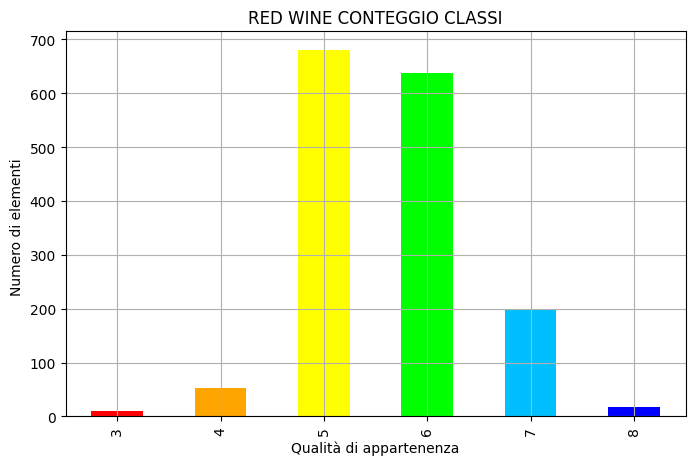

In [25]:
M1, N1 = red_wine.shape
class_cont_freq = pd.concat([red_wine['quality'].value_counts(), red_wine['quality'].value_counts()/M1], axis=1)
class_cont_freq.columns = ['counts', 'freq.']  
class_cont_freq.index.name = 'class'
class_cont_freq.sort_values('class', inplace=True)

display(class_cont_freq)

plt.figure()
class_cont_freq['counts'].plot.bar(figsize=(8,5), color=['red', 'orange', 'yellow', 'lime', 'deepskyblue', 'blue'])
plt.title('RED WINE CONTEGGIO CLASSI')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()
plt.show()

# PROBLEMA BINARIO

Ho diviso il problema di multiclassificazione in un problema binario accorpando le classi.

In [26]:
red_wine_copy = red_wine.copy()
red_wine_copy['quality'].replace([3, 4, 5], value=0, inplace=True)
red_wine_copy['quality'].replace([6, 7, 8], value=1, inplace=True)

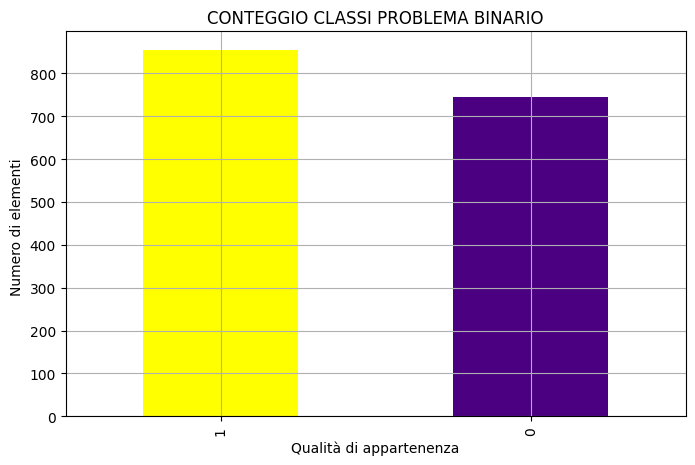

In [27]:
plt.figure()
red_wine_copy['quality'].value_counts().plot.bar(figsize=(8,5), color=['yellow', 'indigo'])
plt.title('CONTEGGIO CLASSI PROBLEMA BINARIO')
plt.xlabel("Qualità di appartenenza")
plt.ylabel("Numero di elementi ")
plt.grid()

# CREAZIONE TRAINING, VALIDATION E TEST SET

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [29]:
X = red_wine_copy.drop('quality', axis=1).values
y = red_wine_copy['quality'].values
y_nomi_classe = ['classe 0', 'classe 1']

random_state = 20210526
test_p = 0.5
val_p = 0.4
indices = np.arange(X.shape[0])

ind_train, ind_test = train_test_split(indices, test_size=test_p, random_state=random_state, shuffle=True)
ind_train, ind_val = train_test_split(ind_train, test_size=val_p, random_state=random_state, shuffle=True)

# GRID SEARCH

In [41]:
import shap
from joblib import Parallel, delayed

In [49]:
n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

hparameters = {
    'svc__kernel': ker_list,
    'svc__C': C_list,
    'svc__gamma': gamma_list
}

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(class_weight='balanced', probability=True))
])

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)

svm_gs.fit(X, y)

best_model = svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])

X_copy = red_wine_copy.drop('quality', axis=1)
# Get the SVM model from the pipeline
svm_model = best_model.named_steps['svc']

# Create the shap.KernelExplainer using the SVM model and the training data
explainer = shap.KernelExplainer(svm_model.predict_proba, X_copy.iloc[ind_train, :])

# Generate SHAP values for a sample of the dataset
sample = X_copy.iloc[ind_test, :]  # assuming X is a pandas DataFrame
shap_values = explainer.shap_values(sample)

# Visualize the SHAP values
shap.summary_plot(shap_values, sample)

Fitting 1 folds for each of 60 candidates, totalling 60 fits


Using 479 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  2%|▏         | 16/800 [57:59<47:21:45, 217.48s/it] 


KeyboardInterrupt: 

In [32]:
n_features = X.shape[1]

C_list = [2 ** i for i in range(-2, 3)]
gamma_list = [1 / (i * n_features) for i in np.arange(0.5, 1.75, 0.5)]
ker_list = ['rbf', 'poly', 'sigmoid', 'linear']

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(class_weight='balanced'))])
hparameters = {'svc__kernel':ker_list, 'svc__C':C_list, 'svc__gamma':gamma_list}

svm_gs = GridSearchCV(pipe, 
                      param_grid=hparameters, 
                      scoring='f1_weighted',
                      return_train_score=True,
                      cv=zip([ind_train], [ind_val]),verbose=True)
svm_gs.fit(X, y)

Fitting 1 folds for each of 60 candidates, totalling 60 fits


GridSearchCV(cv=<zip object at 0x00000260617FDF40>,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [0.25, 0.5, 1, 2, 4],
                         'svc__gamma': [0.18181818181818182,
                                        0.09090909090909091,
                                        0.06060606060606061],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
             return_train_score=True, scoring='f1_weighted', verbose=True)

In [33]:
df_results = pd.DataFrame(svm_gs.cv_results_)

display(df_results.sort_values(['rank_test_score'], ascending=True))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,param_svc__kernel,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
40,0.007614,0.0,0.008392,0.0,2,0.090909,rbf,"{'svc__C': 2, 'svc__gamma': 0.0909090909090909...",0.768497,0.768497,0.0,1,0.834984,0.834984,0.0
24,0.008099,0.0,0.009614,0.0,1,0.181818,rbf,"{'svc__C': 1, 'svc__gamma': 0.1818181818181818...",0.762500,0.762500,0.0,2,0.853805,0.853805,0.0
56,0.006246,0.0,0.008488,0.0,4,0.060606,rbf,"{'svc__C': 4, 'svc__gamma': 0.0606060606060606...",0.759185,0.759185,0.0,3,0.835073,0.835073,0.0
52,0.006063,0.0,0.010181,0.0,4,0.090909,rbf,"{'svc__C': 4, 'svc__gamma': 0.0909090909090909...",0.759034,0.759034,0.0,4,0.853656,0.853656,0.0
16,0.006559,0.0,0.008931,0.0,0.5,0.090909,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.09090909090909...",0.753354,0.753354,0.0,5,0.797576,0.797576,0.0
0,0.008186,0.0,0.013545,0.0,0.25,0.181818,rbf,"{'svc__C': 0.25, 'svc__gamma': 0.1818181818181...",0.753180,0.753180,0.0,6,0.805888,0.805888,0.0
36,0.007534,0.0,0.010401,0.0,2,0.181818,rbf,"{'svc__C': 2, 'svc__gamma': 0.1818181818181818...",0.752775,0.752775,0.0,7,0.880899,0.880899,0.0
20,0.005624,0.0,0.010539,0.0,0.5,0.060606,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.06060606060606...",0.750264,0.750264,0.0,8,0.778679,0.778679,0.0
12,0.007314,0.0,0.011781,0.0,0.5,0.181818,rbf,"{'svc__C': 0.5, 'svc__gamma': 0.18181818181818...",0.747110,0.747110,0.0,9,0.828829,0.828829,0.0
32,0.006030,0.0,0.009481,0.0,1,0.060606,rbf,"{'svc__C': 1, 'svc__gamma': 0.0606060606060606...",0.744020,0.744020,0.0,10,0.799679,0.799679,0.0


In [34]:
# Calcolo delle predizioni sul test set.
# Nomi delle variabili:
#
# y_pred_train: vettore delle predizioni sul training;
# y_true_train: vettore dei target "veri" del training set;
# y_pred_val: vettore delle predizioni sul validation;
# y_true_val: vettore dei target "veri" del validation set;
#
# y_pred: vettore delle predizioni sul test;
# y_true: vettore dei target "veri" del test set

# Ri-addestramento della miglior SVM
svm_gs.best_estimator_.fit(X[ind_train, :], y[ind_train])
model = svm_gs.best_estimator_
import shap
shap_values = shap.Explainer(model, data=X[ind_train, :])
shap.summary_plot(shap_values, X[ind_train, :], plot_type="bar")

y_pred_train = svm_gs.best_estimator_.predict(X[ind_train, :])
y_true_train = y[ind_train]
y_pred_val = svm_gs.best_estimator_.predict(X[ind_val, :])
y_true_val = y[ind_val]

y_pred = svm_gs.best_estimator_.predict(X[ind_test, :])
y_true = y[ind_test]

acc_train = svm_gs.best_estimator_.score(X[ind_train, :], y_true_train)
prec_train = precision_score(y_true_train, y_pred_train, average='weighted')
rec_train = recall_score(y_true_train, y_pred_train, average='weighted')
f1_train = f1_score(y_true_train, y_pred_train, average='weighted')

acc_val = svm_gs.best_estimator_.score(X[ind_val, :], y_true_val)
prec_val = precision_score(y_true_val, y_pred_val, average='weighted')
rec_val = recall_score(y_true_val, y_pred_val, average='weighted')
f1_val = f1_score(y_true_val, y_pred_val, average='weighted')

acc = svm_gs.best_estimator_.score(X[ind_test, :], y_true)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_train, acc_val, acc], 
                        'Precision': [prec_train, prec_val, prec], 
                        'Recall': [rec_train, rec_val, rec],
                        'F1': [f1_train, f1_val, f1]
                       },
                      index=['training', 'validation', 'test'])
cmat = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_)
cmat_norm_true = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='true')
cmat_norm_pred = confusion_matrix(y_true, y_pred, labels=svm_gs.best_estimator_.classes_, normalize='pred')

df_cmat = pd.DataFrame(cmat, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_true = pd.DataFrame(cmat_norm_true, columns=y_nomi_classe, index=y_nomi_classe)
df_cmat_norm_pred = pd.DataFrame(cmat_norm_pred, columns=y_nomi_classe, index=y_nomi_classe)

display(df_perf)
display(df_cmat)
display(df_cmat_norm_true)
display(df_cmat_norm_pred)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(C=2, class_weight='balanced', gamma=0.09090909090909091))])

In [ ]:
M1, N1 = red_wine.loc[ind_train+1, ['quality']].shape
M2, N2 = red_wine.loc[ind_test+1, ['quality']].shape
M3, N3 = red_wine.loc[ind_test+1, ['quality']].shape

class_cont_freq_tr = pd.concat([red_wine.loc[ind_train+1, ['quality']].value_counts(), red_wine.loc[ind_train+1, ['quality']].value_counts()/M1], axis=1)
class_cont_freq_tr.columns = ['counts', 'freq.']  
class_cont_freq_tr.index.names = ['class']
class_cont_freq_tr.sort_values('class', inplace=True)

class_cont_freq_te = pd.concat([red_wine.loc[ind_test+1, ['quality']].value_counts(), red_wine.loc[ind_test+1, ['quality']].value_counts()/M2], axis=1)
class_cont_freq_te.columns = ['counts', 'freq.']  
class_cont_freq_te.index.names = ['class']
class_cont_freq_te.sort_values('class', inplace=True)

class_cont_freq_va = pd.concat([red_wine.loc[ind_val+1, ['quality']].value_counts(), red_wine.loc[ind_val+1, ['quality']].value_counts()/M3], axis=1)
class_cont_freq_va.columns = ['counts', 'freq.']  
class_cont_freq_va.index.names = ['class']
class_cont_freq_va.sort_values('class', inplace=True)

display(class_cont_freq_tr)
display(class_cont_freq_te)
display(class_cont_freq_va)
